<a href="https://colab.research.google.com/github/darsh-2601-Kurmi/Traffic-Prediction-using-GNN-with-Temporal-Multi-head-Attention-Networks-with-City-treated-as-Graph/blob/main/DARSh_3P99.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Loadingh Nessecary Libraries

In [ ]:
!pip install torch torchvision torchaudio torch-geometric
!pip install pandas numpy networkx scipy scikit-learn matplotlib seaborn


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 91.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 69.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 44.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 42.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 66.6 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12


# Loading Data And Creating the Static and Dynamic Graphs

In [ ]:
import pandas as pd
import numpy as np
import networkx as nx
import math


# ==== CONFIG ====
max_dist_v2v = 250   #
max_dist_v2i = 500   #
max_dist_v2r = 350
seconds_to_use = 60   # Only process the first 60 seconds

# ==== LOAD CSVs ====
junctions_df = pd.read_csv("/content/junctions.csv")
edges_df = pd.read_csv("/content/edges_data.csv")
towers_df = pd.read_csv("/content/May 4th Dataset Car and Tower  - Sheet1 - Copy.csv")
car_df = pd.read_csv("/content/car_data_simulation_300_cars.csv", parse_dates=["Time"])  # Use 300 cars dataset

# ==== STEP 1: BUILD STATIC MAP GRAPH ====
Map_graph = nx.Graph()

# Add junctions
for _, row in junctions_df.iterrows():
    node_id = row["Node"]
    pos = (row["x"], row["y"])
    Map_graph.add_node(node_id, pos=pos, type="intersection")

# Add roads & shape points
def parse_shape(from_node, to_node, shape_str):
    if pd.isna(shape_str) or shape_str.strip() == "":
        from_pos = junctions_df[junctions_df["Node"] == from_node][["x", "y"]].values
        to_pos = junctions_df[junctions_df["Node"] == to_node][["x", "y"]].values
        if len(from_pos) == 0 or len(to_pos) == 0:
            return []
        return [tuple(from_pos[0]), tuple(to_pos[0])]
    return [tuple(map(float, point.split(','))) for point in shape_str.split()]

for _, row in edges_df.iterrows():
    from_node, to_node, shape = row["From"], row["To"], row["Shape"]
    points = parse_shape(from_node, to_node, shape)
    if points:
        prev = from_node
        for i, (x, y) in enumerate(points):
            shape_node = f"{from_node}_{to_node}_shape{i}"
            Map_graph.add_node(shape_node, pos=(x, y), type="shape_point")
            Map_graph.add_edge(prev, shape_node)
            prev = shape_node
        Map_graph.add_edge(prev, to_node)
    else:
        Map_graph.add_edge(from_node, to_node)

print("✅ Static Map_graph created.")

# ==== STEP 2: BUILD DYNAMIC GRAPHS (ONE PER SECOND) ====
# Filter to first 60 seconds
car_df = car_df.sort_values("Time")
base_time = car_df["Time"].iloc[0]
car_df["Elapsed"] = (car_df["Time"] - base_time).dt.total_seconds().astype(int)
car_df = car_df[car_df["Elapsed"] < seconds_to_use]

# Preload static nodes (Towers & RSUs)
static_nodes = {}
for _, row in towers_df.iterrows():
    node_id = row["Car ID"]
    node_type = "RSU" if "RSU" in node_id else "Tower"
    static_nodes[node_id] = {"pos": (row["X"], row["Y"]), "type": node_type}

# Prepare dynamic graphs
dynamic_graphs = []

# Manually compute distance
def compute_distance(coord1, coord2):
    """Manually compute Euclidean distance."""
    x1, y1 = coord1
    x2, y2 = coord2
    return math.sqrt((x2 - x1) ** 2 + (y2 - y1) ** 2)

for t in range(seconds_to_use):
    G = nx.Graph()

    # Add static nodes (Towers, RSUs)
    for node_id, attr in static_nodes.items():
        G.add_node(node_id, **attr)

    # Add car nodes for current time
    cars_t = car_df[car_df["Elapsed"] == t]
    car_positions = {}
    for _, row in cars_t.iterrows():
        cid = f"car_{row['ID']}"
        pos = (row["X"], row["Y"])
        car_positions[cid] = pos
        G.add_node(cid, pos=pos, type="car")

    # Add V2V edges
    car_ids = list(car_positions.keys())
    for i in range(len(car_ids)):
        for j in range(i + 1, len(car_ids)):
            c1, c2 = car_ids[i], car_ids[j]
            pos1, pos2 = car_positions[c1], car_positions[c2]
            dist = compute_distance(pos1, pos2)  # Manually compute distance
            if dist <= max_dist_v2v:
                G.add_edge(c1, c2, type="V2V", weight=1 / (dist + 1e-5))

    # Add V2I and V2R edges
    for car_id, car_pos in car_positions.items():
        for static_id, static_info in static_nodes.items():
            static_type = static_info["type"]
            max_range = max_dist_v2i if static_type == "Tower" else max_dist_v2r
            dist = compute_distance(car_pos, static_info["pos"])  # Manually compute distance
            if dist <= max_range:
                edge_type = "V2I" if static_type == "Tower" else "V2R"
                G.add_edge(car_id, static_id, type=edge_type, weight=1 / (dist + 1e-5))

    dynamic_graphs.append(G)

print(f"✅ Created {len(dynamic_graphs)} dynamic networking graphs for 300 cars (1 per second)")

✅ Static Map_graph created.
✅ Created 60 dynamic networking graphs for 300 cars (1 per second)


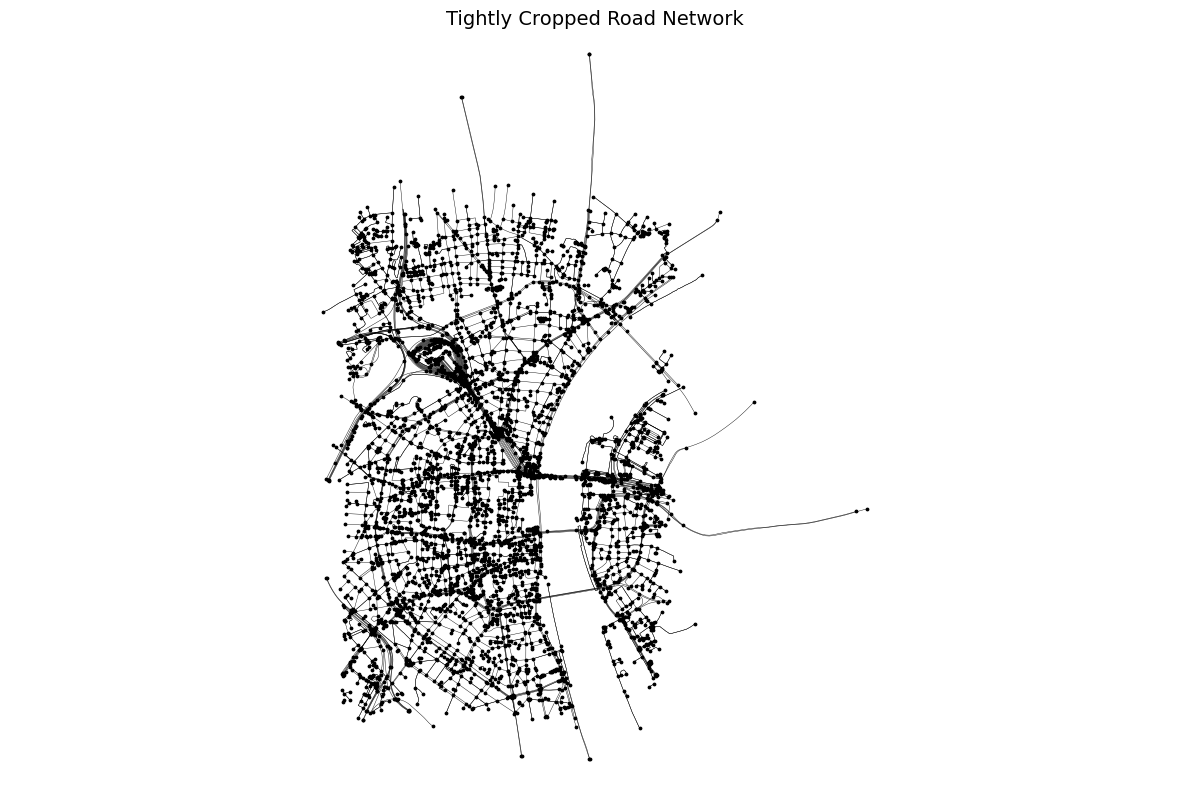

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# ==== Collect all coordinates ====
all_x, all_y = [], []

plt.figure(figsize=(12, 8))

# Plot roads with shape points
for _, row in edges_df.iterrows():
    from_node, to_node, shape = row["From"], row["To"], row["Shape"]

    if pd.isna(shape) or shape.strip() == "":
        from_pos = junctions_df[junctions_df["Node"] == from_node][["x", "y"]].values
        to_pos = junctions_df[junctions_df["Node"] == to_node][["x", "y"]].values
        if len(from_pos) == 0 or len(to_pos) == 0:
            continue
        xs = [from_pos[0][0], to_pos[0][0]]
        ys = [from_pos[0][1], to_pos[0][1]]
    else:
        points = [tuple(map(float, p.split(','))) for p in shape.strip().split()]
        xs, ys = zip(*points)

    all_x.extend(xs)
    all_y.extend(ys)

    plt.plot(xs, ys, color='black', linewidth=0.3)

# Plot junctions
plt.scatter(junctions_df["x"], junctions_df["y"], s=3, color='black')

# ==== Auto-fit axes to data ====
padding = 5  # Add small margin
min_x, max_x = min(all_x), max(all_x)
min_y, max_y = min(all_y), max(all_y)
plt.xlim(min_x - padding, max_x + padding)
plt.ylim(min_y - padding, max_y + padding)

plt.title("Tightly Cropped Road Network", fontsize=14)
plt.axis('equal')
plt.axis('off')
plt.tight_layout()
plt.show()


# Converting to PyGeometric Format


In [ ]:
from scipy.spatial import KDTree
import torch
from torch_geometric.data import Data

# 🚀 Convert "State" column to numerical encoding
state_mapping = {"moving": 1.0, "stopped": 0.0, "idle": 0.5}

def convert_state(state_value):
    """Convert state text to a numeric value."""
    return state_mapping.get(state_value.lower(), 0.0) if isinstance(state_value, str) else 0.0

# 🚀 Create a KDTree for fast nearest neighbor search of intersections
intersection_nodes = [n for n, d in Map_graph.nodes(data=True) if d["type"] == "intersection"]
intersection_positions = np.array([Map_graph.nodes[n]["pos"] for n in intersection_nodes])
kd_tree = KDTree(intersection_positions)

def get_nearest_intersection(x, y):
    """Finds the nearest intersection and distance to it."""
    dist, idx = kd_tree.query((x, y))
    nearest_intersection = intersection_nodes[idx]
    return nearest_intersection, dist

# 🚀 Add Features to Dynamic Graphs
for t, G in enumerate(dynamic_graphs):
    for node, data in G.nodes(data=True):
        if data["type"] == "car":
            x, y = data["pos"]

            # Get car attributes from the dataset
            car_id = int(node.split("_")[1])
            car_row = car_df[(car_df["Elapsed"] == t) & (car_df["ID"] == car_id)]

            if car_row.empty:
                print(f"⚠️ Warning: No data found for Car {car_id} at Time {t}")

            if not car_row.empty:
                speed = float(car_row["Speed"].values[0]) if pd.notna(car_row["Speed"].values[0]) else 0.0
                direction = float(car_row["Direction"].values[0]) if pd.notna(car_row["Direction"].values[0]) else 0.0
                state = convert_state(car_row["State"].values[0])  # Convert state
                download = float(car_row["Download"].values[0]) if pd.notna(car_row["Download"].values[0]) else 0.0
                upload = float(car_row["Upload"].values[0]) if pd.notna(car_row["Upload"].values[0]) else 0.0
            else:
                speed, direction, state, download, upload = 0.0, 0.0, 0.0, 0.0, 0.0


            # Find nearest intersection & distance
            nearest_intersection, dist_to_intersection = get_nearest_intersection(x, y)

            # Check if the car is AT an intersection
            is_at_intersection = 1.0 if dist_to_intersection < 20 else 0.0

            # Add features to the car node
            G.nodes[node]["dist_to_intersection"] = float(dist_to_intersection)
            G.nodes[node]["is_at_intersection"] = is_at_intersection
            G.nodes[node]["speed"] = speed
            G.nodes[node]["direction"] = direction
            G.nodes[node]["state"] = state
            G.nodes[node]["download"] = download
            G.nodes[node]["upload"] = upload

# 🚀 Convert to PyTorch Geometric Format
graph_data_list = []

for t, G in enumerate(dynamic_graphs):
    node_features = []
    pos_list = []

    node_mapping = {n: i for i, n in enumerate(G.nodes())}

    for node, data in G.nodes(data=True):
        pos_list.append(data["pos"])

        if data["type"] == "car":
            # 🚀 Debugging: Print feature values before adding
            #rint(f"Processing Node {node}: {data}")

            features = [
                float(data["is_at_intersection"]),
                float(data["dist_to_intersection"]),
                float(data["speed"]),
                float(data["direction"]),
                float(data["state"]),
                float(data["download"]),
                float(data["upload"])
            ]
        else:
            # Towers/RSUs don't need extra features
            features = [0.0] * 7

        node_features.append(features)


    import numpy as np

    x = torch.tensor(np.array(node_features, dtype=np.float32), dtype=torch.float)

    pos = torch.tensor(np.array(pos_list, dtype=np.float32), dtype=torch.float)

    # Convert edges
    edge_index = []
    edge_attr = []

    for u, v, data in G.edges(data=True):
        edge_index.append([node_mapping[u], node_mapping[v]])

        # Edge features (Type encoding: 1 = V2V, 2 = V2I, 3 = V2R)
        edge_attr.append([1.0 if data["type"] == "V2V" else 2.0 if data["type"] == "V2I" else 3.0])

    edge_index = torch.tensor(edge_index, dtype=torch.long).t().contiguous()
    edge_attr = torch.tensor(edge_attr, dtype=torch.float)

    # Create PyTorch Geometric Data object
    data = Data(x=x, edge_index=edge_index, edge_attr=edge_attr, pos=pos)
    graph_data_list.append(data)

print("✅ Successfully converted to PyTorch Geometric format!")


✅ Successfully converted to PyTorch Geometric format!


In [ ]:
import torch

# We'll loop over each dynamic graph and verify the PyTorch Geometric Data tensor
for t, G in enumerate(dynamic_graphs):
    node_features = []
    pos_list = []
    node_mapping = {n: i for i, n in enumerate(G.nodes())}

    for node, data in G.nodes(data=True):
        pos_list.append(data["pos"])

        # For car nodes, use the updated features; static nodes keep zeros
        if data["type"] == "car":
            features = [
                float(data.get("is_at_intersection", 0.0)),
                float(data.get("dist_to_intersection", 0.0)),
                float(data.get("speed", 0.0)),
                float(data.get("direction", 0.0)),
                float(data.get("state", 0.0)),
                float(data.get("download", 0.0)),
                float(data.get("upload", 0.0))
            ]
        else:
            features = [0.0] * 7  # Static nodes (e.g. Towers/RSUs)
        node_features.append(features)

    # Convert directly to torch tensors
    x_tensor = torch.tensor(node_features, dtype=torch.float)
    pos_tensor = torch.tensor(pos_list, dtype=torch.float)

    # Build edge indices and attributes (same as before)
    edge_index = []
    edge_attr = []
    for u, v, edata in G.edges(data=True):
        edge_index.append([node_mapping[u], node_mapping[v]])
        etype = edata["type"]
        if etype == "V2V":
            edge_attr.append([1.0])
        elif etype == "V2I":
            edge_attr.append([2.0])
        else:  # V2R
            edge_attr.append([3.0])

    if edge_index:
        edge_index_tensor = torch.tensor(edge_index, dtype=torch.long).t().contiguous()
    else:
        edge_index_tensor = torch.empty((2,0), dtype=torch.long)
    edge_attr_tensor = torch.tensor(edge_attr, dtype=torch.float)

    # Count non-zero rows (if any car node has nonzero features, they should appear)
    nonzero_count = (x_tensor.sum(dim=1) != 0).sum().item()
    unique_rows = torch.unique(x_tensor, dim=0)


# Creating GNN with TA Model


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv

class GNNWithTemporalAttention(nn.Module):
    def __init__(self, in_channels=7, hidden_dim=128, proj_dim=64, heads=4):
        super().__init__()

        # Spatial GNN layers
        self.gnn1 = GCNConv(in_channels, hidden_dim)
        self.gnn2 = GCNConv(hidden_dim, hidden_dim)

        # Temporal Attention Layer
        self.attn = nn.MultiheadAttention(embed_dim=hidden_dim, num_heads=heads, batch_first=True)

        # Final projection
        self.proj = nn.Linear(hidden_dim, proj_dim)

    def forward(self, graph_sequence, masks):
        embeddings = []

        for g, mask in zip(graph_sequence, masks):
            g = g.to(next(self.parameters()).device)
            mask = mask.to(next(self.parameters()).device)

            x = F.relu(self.gnn1(g.x, g.edge_index))
            x = F.relu(self.gnn2(x, g.edge_index))

            embeddings.append(x[mask])  # only car nodes

        # Shape: [T, N, F] → [N, T, F]
        car_sequence = torch.stack(embeddings)         # [T, N, F]
        car_sequence = car_sequence.permute(1, 0, 2)   # [N, T, F]

        # Temporal attention
        attn_out, _ = self.attn(car_sequence, car_sequence, car_sequence)  # [N, T, F]
        final_embeddings = attn_out[:, -1, :]  # [N, F] - last timestep attention summary

        return self.proj(final_embeddings)     # [N, proj_dim]


Intialize Model

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ⬇️ Initialize the model
model = GNNWithTemporalAttention(in_channels=7, hidden_dim=128, proj_dim=64, heads=4).to(device)

# ⬇️ Optimizer and scheduler
optimizer = torch.optim.AdamW(model.parameters(), lr=0.0007, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=500, gamma=0.9)
loss_fn = torch.nn.MSELoss()

# Time windows
input_len = 50
target_offset = 10
start = 0
target_index = start + input_len + target_offset - 1

# ⬇️ Build graph sequence
input_seq = [g.to(device) for g in graph_data_list[start:start + input_len]]

# ⬇️ Car node masks (per timestep)
car_masks = [
    torch.tensor([attr["type"] == "car" for _, attr in dynamic_graphs[t].nodes(data=True)], dtype=torch.bool).to(device)
    for t in range(start, start + input_len)
]

# ⬇️ Target graph embedding (actual t+10)
with torch.no_grad():
    future_g = graph_data_list[target_index].to(device)
    future_mask = torch.tensor([attr["type"] == "car" for _, attr in dynamic_graphs[target_index].nodes(data=True)], dtype=torch.bool).to(device)

    # Pass through spatial GNN only
    x = F.relu(model.gnn1(future_g.x, future_g.edge_index))
    x = F.relu(model.gnn2(x, future_g.edge_index))

    target_embeddings = model.proj(x[future_mask])  # Shape: [N, proj_dim]


# Training Loop

In [ ]:
import numpy as np
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, r2_score

# Lists to store the metrics at each logging interval
logged_epochs   = []
logged_mse      = []
logged_r2       = []
logged_mean_cos = []
logged_mean_diff= []
logged_accuracy = []
logged_precision= []
logged_recall   = []
logged_f1       = []
logged_auc      = []
logged_top1     = []
logged_top5     = []

epochs = 3500
model.train()

for epoch in range(epochs):
    optimizer.zero_grad()

    # 🔮 Predict per-car embeddings from graph sequence
    pred_embeddings = model(input_seq, car_masks)  # Shape: [N, proj_dim]

    # 🎯 Compute MSE Loss
    loss = loss_fn(pred_embeddings, target_embeddings)

    # 🚀 Backpropagation
    loss.backward()
    optimizer.step()
    scheduler.step()

    # ✅ Logging every 100 epochs or at final epoch
    if epoch % 100 == 0 or epoch == epochs - 1:
        # Compute cosine similarity for each car node
        cos_sim = F.cosine_similarity(pred_embeddings, target_embeddings, dim=1)  # [N]

        # Regression metrics: MSE and R²
        mse_value = loss.item()
        ss_res    = torch.sum((target_embeddings - pred_embeddings) ** 2)
        ss_tot    = torch.sum((target_embeddings - target_embeddings.mean(dim=0)) ** 2)
        r2_value  = 1 - ss_res / (ss_tot + 1e-8)

        # --- Classification-like metrics simulation ---
        threshold = 0.8
        cos_sim_np = cos_sim.detach().cpu().numpy()
        labels = np.ones_like(cos_sim_np).astype(int)
        preds  = (cos_sim_np >= threshold).astype(int)

        tp = int(np.sum(preds == 1))
        fn = int(np.sum(preds == 0))
        tn = 0
        fp = 0
        accuracy = np.mean(preds == labels)
        precision= tp / (tp + fp + 1e-8)
        recall   = tp / (tp + fn + 1e-8)
        f1       = 2 * precision * recall / (precision + recall + 1e-8)
        try:
            auc_simple = roc_auc_score(labels, cos_sim_np)
        except Exception:
            auc_simple = float('nan')

        # Additional metric: Mean difference norm between predictions and targets
        diff_norm = (pred_embeddings - target_embeddings).norm(dim=1).mean().item()

        # --- Matching-based AUC & Top-K ---
        pred_cpu = pred_embeddings.detach().cpu()
        target_cpu = target_embeddings.detach().cpu()
        auc_list = []
        top1_count = 0
        top5_count = 0

        for i in range(pred_cpu.shape[0]):
            pred_vec = pred_cpu[i]
            sims = F.cosine_similarity(pred_vec.unsqueeze(0), target_cpu).numpy()  # shape: [N]
            labels = np.zeros_like(sims)
            labels[i] = 1

            if np.unique(labels).size == 2:
                try:
                    auc = roc_auc_score(labels, sims)
                    auc_list.append(auc)
                except:
                    pass

            # Top-K ranking
            top_k_indices = np.argsort(sims)[::-1]  # descending
            if top_k_indices[0] == i:
                top1_count += 1
            if i in top_k_indices[:5]:
                top5_count += 1

        mean_auc = np.mean(auc_list) if auc_list else float('nan')
        top1_acc = top1_count / pred_cpu.shape[0]
        top5_acc = top5_count / pred_cpu.shape[0]

        # Print out current metrics
        print(f"[Epoch {epoch}] MSE: {mse_value:.4f} | R²: {r2_value.item():.4f} | Mean CosSim: {cos_sim.mean().item():.4f} | Mean ΔNorm: {diff_norm:.2f}")
        print(f"Classification-like -> TP: {tp}, TN: {tn}, FP: {fp}, FN: {fn}")
        print(f"Accuracy: {accuracy:.4f} | Precision: {precision:.4f} | Recall: {recall:.4f} | F1: {f1:.4f} | AUC (1-class): {auc_simple:.4f}")
        print(f"Matching-based AUC: {mean_auc:.4f} | Top-1 Acc: {top1_acc:.4f} | Top-5 Acc: {top5_acc:.4f}\n")

        # Save metrics for visualization after training
        logged_epochs.append(epoch)
        logged_mse.append(mse_value)
        logged_r2.append(r2_value.item())
        logged_mean_cos.append(cos_sim.mean().item())
        logged_mean_diff.append(diff_norm)
        logged_accuracy.append(accuracy)
        logged_precision.append(precision)
        logged_recall.append(recall)
        logged_f1.append(f1)
        logged_auc.append(mean_auc)
        logged_top1.append(top1_acc)
        logged_top5.append(top5_acc)


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(


[Epoch 0] MSE: 116.5325 | R²: -3.8229 | Mean CosSim: 0.2460 | Mean ΔNorm: 81.17
Classification-like -> TP: 0, TN: 0, FP: 0, FN: 300
Accuracy: 0.0000 | Precision: 0.0000 | Recall: 0.0000 | F1: 0.0000 | AUC (1-class): nan
Matching-based AUC: 0.5019 | Top-1 Acc: 0.0033 | Top-5 Acc: 0.0167



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(


[Epoch 100] MSE: 17.9286 | R²: 0.2580 | Mean CosSim: 0.9820 | Mean ΔNorm: 28.87
Classification-like -> TP: 295, TN: 0, FP: 0, FN: 5
Accuracy: 0.9833 | Precision: 1.0000 | Recall: 0.9833 | F1: 0.9916 | AUC (1-class): nan
Matching-based AUC: 0.5103 | Top-1 Acc: 0.0033 | Top-5 Acc: 0.0167



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(


[Epoch 200] MSE: 16.2748 | R²: 0.3264 | Mean CosSim: 0.9844 | Mean ΔNorm: 26.97
Classification-like -> TP: 295, TN: 0, FP: 0, FN: 5
Accuracy: 0.9833 | Precision: 1.0000 | Recall: 0.9833 | F1: 0.9916 | AUC (1-class): nan
Matching-based AUC: 0.5084 | Top-1 Acc: 0.0033 | Top-5 Acc: 0.0167



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(


[Epoch 300] MSE: 14.9913 | R²: 0.3796 | Mean CosSim: 0.9860 | Mean ΔNorm: 25.41
Classification-like -> TP: 295, TN: 0, FP: 0, FN: 5
Accuracy: 0.9833 | Precision: 1.0000 | Recall: 0.9833 | F1: 0.9916 | AUC (1-class): nan
Matching-based AUC: 0.5122 | Top-1 Acc: 0.0067 | Top-5 Acc: 0.0200



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(


[Epoch 400] MSE: 13.3766 | R²: 0.4464 | Mean CosSim: 0.9863 | Mean ΔNorm: 24.10
Classification-like -> TP: 296, TN: 0, FP: 0, FN: 4
Accuracy: 0.9867 | Precision: 1.0000 | Recall: 0.9867 | F1: 0.9933 | AUC (1-class): nan
Matching-based AUC: 0.5149 | Top-1 Acc: 0.0067 | Top-5 Acc: 0.0200



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(


[Epoch 500] MSE: 12.0879 | R²: 0.4997 | Mean CosSim: 0.9783 | Mean ΔNorm: 22.82
Classification-like -> TP: 295, TN: 0, FP: 0, FN: 5
Accuracy: 0.9833 | Precision: 1.0000 | Recall: 0.9833 | F1: 0.9916 | AUC (1-class): nan
Matching-based AUC: 0.5222 | Top-1 Acc: 0.0033 | Top-5 Acc: 0.0167



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(


[Epoch 600] MSE: 9.7362 | R²: 0.5971 | Mean CosSim: 0.9819 | Mean ΔNorm: 19.98
Classification-like -> TP: 293, TN: 0, FP: 0, FN: 7
Accuracy: 0.9767 | Precision: 1.0000 | Recall: 0.9767 | F1: 0.9882 | AUC (1-class): nan
Matching-based AUC: 0.5245 | Top-1 Acc: 0.0033 | Top-5 Acc: 0.0233



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(


[Epoch 700] MSE: 11.0088 | R²: 0.5444 | Mean CosSim: 0.9878 | Mean ΔNorm: 22.06
Classification-like -> TP: 296, TN: 0, FP: 0, FN: 4
Accuracy: 0.9867 | Precision: 1.0000 | Recall: 0.9867 | F1: 0.9933 | AUC (1-class): nan
Matching-based AUC: 0.5224 | Top-1 Acc: 0.0000 | Top-5 Acc: 0.0200



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(


[Epoch 800] MSE: 8.5299 | R²: 0.6470 | Mean CosSim: 0.9845 | Mean ΔNorm: 18.68
Classification-like -> TP: 296, TN: 0, FP: 0, FN: 4
Accuracy: 0.9867 | Precision: 1.0000 | Recall: 0.9867 | F1: 0.9933 | AUC (1-class): nan
Matching-based AUC: 0.5365 | Top-1 Acc: 0.0067 | Top-5 Acc: 0.0267



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(


[Epoch 900] MSE: 6.9559 | R²: 0.7121 | Mean CosSim: 0.9865 | Mean ΔNorm: 16.51
Classification-like -> TP: 295, TN: 0, FP: 0, FN: 5
Accuracy: 0.9833 | Precision: 1.0000 | Recall: 0.9833 | F1: 0.9916 | AUC (1-class): nan
Matching-based AUC: 0.5464 | Top-1 Acc: 0.0033 | Top-5 Acc: 0.0200



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(


[Epoch 1000] MSE: 6.1978 | R²: 0.7435 | Mean CosSim: 0.9880 | Mean ΔNorm: 15.55
Classification-like -> TP: 296, TN: 0, FP: 0, FN: 4
Accuracy: 0.9867 | Precision: 1.0000 | Recall: 0.9867 | F1: 0.9933 | AUC (1-class): nan
Matching-based AUC: 0.5473 | Top-1 Acc: 0.0033 | Top-5 Acc: 0.0267



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(


[Epoch 1100] MSE: 5.6364 | R²: 0.7667 | Mean CosSim: 0.9807 | Mean ΔNorm: 14.48
Classification-like -> TP: 295, TN: 0, FP: 0, FN: 5
Accuracy: 0.9833 | Precision: 1.0000 | Recall: 0.9833 | F1: 0.9916 | AUC (1-class): nan
Matching-based AUC: 0.5686 | Top-1 Acc: 0.0100 | Top-5 Acc: 0.0500



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(


[Epoch 1200] MSE: 4.8246 | R²: 0.8003 | Mean CosSim: 0.9883 | Mean ΔNorm: 13.51
Classification-like -> TP: 297, TN: 0, FP: 0, FN: 3
Accuracy: 0.9900 | Precision: 1.0000 | Recall: 0.9900 | F1: 0.9950 | AUC (1-class): nan
Matching-based AUC: 0.5560 | Top-1 Acc: 0.0033 | Top-5 Acc: 0.0233



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(


[Epoch 1300] MSE: 4.4118 | R²: 0.8174 | Mean CosSim: 0.9896 | Mean ΔNorm: 12.84
Classification-like -> TP: 297, TN: 0, FP: 0, FN: 3
Accuracy: 0.9900 | Precision: 1.0000 | Recall: 0.9900 | F1: 0.9950 | AUC (1-class): nan
Matching-based AUC: 0.5643 | Top-1 Acc: 0.0067 | Top-5 Acc: 0.0267



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(


[Epoch 1400] MSE: 4.0817 | R²: 0.8311 | Mean CosSim: 0.9859 | Mean ΔNorm: 12.19
Classification-like -> TP: 296, TN: 0, FP: 0, FN: 4
Accuracy: 0.9867 | Precision: 1.0000 | Recall: 0.9867 | F1: 0.9933 | AUC (1-class): nan
Matching-based AUC: 0.5680 | Top-1 Acc: 0.0067 | Top-5 Acc: 0.0300



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(


[Epoch 1500] MSE: 3.9658 | R²: 0.8359 | Mean CosSim: 0.9899 | Mean ΔNorm: 12.56
Classification-like -> TP: 297, TN: 0, FP: 0, FN: 3
Accuracy: 0.9900 | Precision: 1.0000 | Recall: 0.9900 | F1: 0.9950 | AUC (1-class): nan
Matching-based AUC: 0.5611 | Top-1 Acc: 0.0067 | Top-5 Acc: 0.0300



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(


[Epoch 1600] MSE: 3.5492 | R²: 0.8531 | Mean CosSim: 0.9896 | Mean ΔNorm: 11.59
Classification-like -> TP: 298, TN: 0, FP: 0, FN: 2
Accuracy: 0.9933 | Precision: 1.0000 | Recall: 0.9933 | F1: 0.9967 | AUC (1-class): nan
Matching-based AUC: 0.5710 | Top-1 Acc: 0.0100 | Top-5 Acc: 0.0267



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(


[Epoch 1700] MSE: 3.2574 | R²: 0.8652 | Mean CosSim: 0.9879 | Mean ΔNorm: 10.84
Classification-like -> TP: 297, TN: 0, FP: 0, FN: 3
Accuracy: 0.9900 | Precision: 1.0000 | Recall: 0.9900 | F1: 0.9950 | AUC (1-class): nan
Matching-based AUC: 0.5755 | Top-1 Acc: 0.0100 | Top-5 Acc: 0.0333



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(


[Epoch 1800] MSE: 3.1835 | R²: 0.8682 | Mean CosSim: 0.9899 | Mean ΔNorm: 11.09
Classification-like -> TP: 299, TN: 0, FP: 0, FN: 1
Accuracy: 0.9967 | Precision: 1.0000 | Recall: 0.9967 | F1: 0.9983 | AUC (1-class): nan
Matching-based AUC: 0.5713 | Top-1 Acc: 0.0133 | Top-5 Acc: 0.0300



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(


[Epoch 1900] MSE: 3.1718 | R²: 0.8687 | Mean CosSim: 0.9882 | Mean ΔNorm: 10.84
Classification-like -> TP: 298, TN: 0, FP: 0, FN: 2
Accuracy: 0.9933 | Precision: 1.0000 | Recall: 0.9933 | F1: 0.9967 | AUC (1-class): nan
Matching-based AUC: 0.5797 | Top-1 Acc: 0.0100 | Top-5 Acc: 0.0300



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(


[Epoch 2000] MSE: 3.2916 | R²: 0.8638 | Mean CosSim: 0.9723 | Mean ΔNorm: 11.18
Classification-like -> TP: 293, TN: 0, FP: 0, FN: 7
Accuracy: 0.9767 | Precision: 1.0000 | Recall: 0.9767 | F1: 0.9882 | AUC (1-class): nan
Matching-based AUC: 0.5996 | Top-1 Acc: 0.0167 | Top-5 Acc: 0.0533



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(


[Epoch 2100] MSE: 2.9682 | R²: 0.8772 | Mean CosSim: 0.9901 | Mean ΔNorm: 10.87
Classification-like -> TP: 299, TN: 0, FP: 0, FN: 1
Accuracy: 0.9967 | Precision: 1.0000 | Recall: 0.9967 | F1: 0.9983 | AUC (1-class): nan
Matching-based AUC: 0.5761 | Top-1 Acc: 0.0100 | Top-5 Acc: 0.0200



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(


[Epoch 2200] MSE: 2.7169 | R²: 0.8876 | Mean CosSim: 0.9813 | Mean ΔNorm: 9.92
Classification-like -> TP: 297, TN: 0, FP: 0, FN: 3
Accuracy: 0.9900 | Precision: 1.0000 | Recall: 0.9900 | F1: 0.9950 | AUC (1-class): nan
Matching-based AUC: 0.6028 | Top-1 Acc: 0.0200 | Top-5 Acc: 0.0500



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(


[Epoch 2300] MSE: 2.4775 | R²: 0.8975 | Mean CosSim: 0.9854 | Mean ΔNorm: 9.32
Classification-like -> TP: 297, TN: 0, FP: 0, FN: 3
Accuracy: 0.9900 | Precision: 1.0000 | Recall: 0.9900 | F1: 0.9950 | AUC (1-class): nan
Matching-based AUC: 0.5989 | Top-1 Acc: 0.0133 | Top-5 Acc: 0.0433



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(


[Epoch 2400] MSE: 3.0433 | R²: 0.8740 | Mean CosSim: 0.9905 | Mean ΔNorm: 11.52
Classification-like -> TP: 299, TN: 0, FP: 0, FN: 1
Accuracy: 0.9967 | Precision: 1.0000 | Recall: 0.9967 | F1: 0.9983 | AUC (1-class): nan
Matching-based AUC: 0.5744 | Top-1 Acc: 0.0067 | Top-5 Acc: 0.0233



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(


[Epoch 2500] MSE: 2.2357 | R²: 0.9075 | Mean CosSim: 0.9896 | Mean ΔNorm: 8.95
Classification-like -> TP: 298, TN: 0, FP: 0, FN: 2
Accuracy: 0.9933 | Precision: 1.0000 | Recall: 0.9933 | F1: 0.9967 | AUC (1-class): nan
Matching-based AUC: 0.5931 | Top-1 Acc: 0.0167 | Top-5 Acc: 0.0267



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(


[Epoch 2600] MSE: 2.6950 | R²: 0.8885 | Mean CosSim: 0.9725 | Mean ΔNorm: 10.29
Classification-like -> TP: 295, TN: 0, FP: 0, FN: 5
Accuracy: 0.9833 | Precision: 1.0000 | Recall: 0.9833 | F1: 0.9916 | AUC (1-class): nan
Matching-based AUC: 0.6153 | Top-1 Acc: 0.0233 | Top-5 Acc: 0.0500



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(


[Epoch 2700] MSE: 2.1552 | R²: 0.9108 | Mean CosSim: 0.9901 | Mean ΔNorm: 9.09
Classification-like -> TP: 298, TN: 0, FP: 0, FN: 2
Accuracy: 0.9933 | Precision: 1.0000 | Recall: 0.9933 | F1: 0.9967 | AUC (1-class): nan
Matching-based AUC: 0.5907 | Top-1 Acc: 0.0100 | Top-5 Acc: 0.0200



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(


[Epoch 2800] MSE: 2.0212 | R²: 0.9163 | Mean CosSim: 0.9819 | Mean ΔNorm: 8.46
Classification-like -> TP: 296, TN: 0, FP: 0, FN: 4
Accuracy: 0.9867 | Precision: 1.0000 | Recall: 0.9867 | F1: 0.9933 | AUC (1-class): nan
Matching-based AUC: 0.6107 | Top-1 Acc: 0.0133 | Top-5 Acc: 0.0467



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(


[Epoch 2900] MSE: 1.8431 | R²: 0.9237 | Mean CosSim: 0.9895 | Mean ΔNorm: 7.93
Classification-like -> TP: 298, TN: 0, FP: 0, FN: 2
Accuracy: 0.9933 | Precision: 1.0000 | Recall: 0.9933 | F1: 0.9967 | AUC (1-class): nan
Matching-based AUC: 0.6054 | Top-1 Acc: 0.0100 | Top-5 Acc: 0.0367



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(


[Epoch 3000] MSE: 2.8103 | R²: 0.8837 | Mean CosSim: 0.9818 | Mean ΔNorm: 10.45
Classification-like -> TP: 296, TN: 0, FP: 0, FN: 4
Accuracy: 0.9867 | Precision: 1.0000 | Recall: 0.9867 | F1: 0.9933 | AUC (1-class): nan
Matching-based AUC: 0.6026 | Top-1 Acc: 0.0067 | Top-5 Acc: 0.0400



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(


[Epoch 3100] MSE: 1.7742 | R²: 0.9266 | Mean CosSim: 0.9870 | Mean ΔNorm: 8.06
Classification-like -> TP: 296, TN: 0, FP: 0, FN: 4
Accuracy: 0.9867 | Precision: 1.0000 | Recall: 0.9867 | F1: 0.9933 | AUC (1-class): nan
Matching-based AUC: 0.6120 | Top-1 Acc: 0.0100 | Top-5 Acc: 0.0333



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(


[Epoch 3200] MSE: 1.8143 | R²: 0.9249 | Mean CosSim: 0.9838 | Mean ΔNorm: 8.30
Classification-like -> TP: 293, TN: 0, FP: 0, FN: 7
Accuracy: 0.9767 | Precision: 1.0000 | Recall: 0.9767 | F1: 0.9882 | AUC (1-class): nan
Matching-based AUC: 0.6213 | Top-1 Acc: 0.0167 | Top-5 Acc: 0.0500



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(


[Epoch 3300] MSE: 1.5616 | R²: 0.9354 | Mean CosSim: 0.9891 | Mean ΔNorm: 7.43
Classification-like -> TP: 297, TN: 0, FP: 0, FN: 3
Accuracy: 0.9900 | Precision: 1.0000 | Recall: 0.9900 | F1: 0.9950 | AUC (1-class): nan
Matching-based AUC: 0.6122 | Top-1 Acc: 0.0133 | Top-5 Acc: 0.0267



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(


[Epoch 3400] MSE: 1.4980 | R²: 0.9380 | Mean CosSim: 0.9885 | Mean ΔNorm: 7.25
Classification-like -> TP: 297, TN: 0, FP: 0, FN: 3
Accuracy: 0.9900 | Precision: 1.0000 | Recall: 0.9900 | F1: 0.9950 | AUC (1-class): nan
Matching-based AUC: 0.6160 | Top-1 Acc: 0.0100 | Top-5 Acc: 0.0367



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(


[Epoch 3499] MSE: 1.4628 | R²: 0.9395 | Mean CosSim: 0.9890 | Mean ΔNorm: 7.19
Classification-like -> TP: 297, TN: 0, FP: 0, FN: 3
Accuracy: 0.9900 | Precision: 1.0000 | Recall: 0.9900 | F1: 0.9950 | AUC (1-class): nan
Matching-based AUC: 0.6172 | Top-1 Acc: 0.0067 | Top-5 Acc: 0.0400



In [ ]:
import torch
import torch.nn.functional as F
from sklearn.metrics import roc_auc_score
import numpy as np

all_aucs = []

pred_embeddings_np = pred_embeddings.detach().cpu()
target_embeddings_np = target_embeddings.detach().cpu()

for i in range(pred_embeddings_np.shape[0]):
    # 1. Get predicted embedding for car i
    pred = pred_embeddings_np[i]  # shape: [D]

    # 2. Compare with all ground truth embeddings using cosine similarity
    similarities = F.cosine_similarity(pred.unsqueeze(0), target_embeddings_np)  # shape: [300]
    similarities = similarities.numpy()

    # 3. Construct binary labels: only index i is the positive
    labels = np.zeros_like(similarities)
    labels[i] = 1

    # 4. Compute AUC (only defined if there are both classes)
    if np.unique(labels).size == 2:
        auc = roc_auc_score(labels, similarities)
        all_aucs.append(auc)

# 5. Aggregate AUC
mean_auc = np.mean(all_aucs) if all_aucs else float('nan')
print(f"🔍 Matching-based AUC across all cars: {mean_auc:.4f}")


🔍 Matching-based AUC across all cars: 0.6988


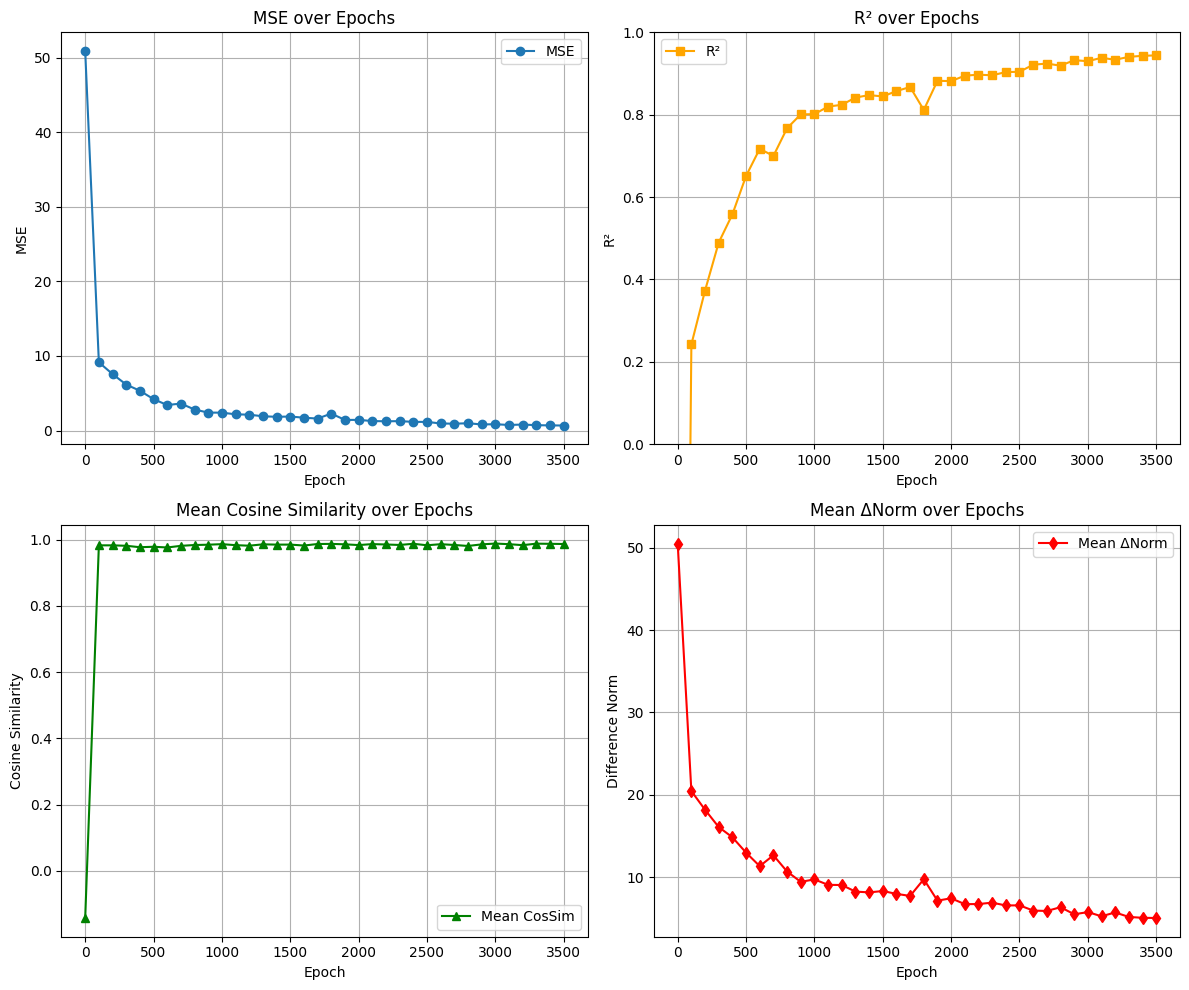

In [ ]:
# ========================
# Visualization Section
# ========================

# 1. Plotting the regression metrics (MSE, R², Mean Cosine Similarity, Mean ΔNorm)
fig, axs = plt.subplots(2, 2, figsize=(12, 10))

# MSE Plot
axs[0,0].plot(logged_epochs, logged_mse, marker='o', label='MSE')
axs[0,0].set_title('MSE over Epochs')
axs[0,0].set_xlabel('Epoch')
axs[0,0].set_ylabel('MSE')
axs[0,0].legend()
axs[0,0].grid(True)

# R² Plot
axs[0,1].plot(logged_epochs, logged_r2, marker='s', color='orange', label='R²')
axs[0,1].set_title('R² over Epochs')
axs[0,1].set_xlabel('Epoch')
axs[0,1].set_ylabel('R²')
axs[0,1].set_ylim(0, 1)  # <-- This limits the y-axis to 0–1
axs[0,1].legend()
axs[0,1].grid(True)


# Mean Cosine Similarity Plot
axs[1,0].plot(logged_epochs, logged_mean_cos, marker='^', color='green', label='Mean CosSim')
axs[1,0].set_title('Mean Cosine Similarity over Epochs')
axs[1,0].set_xlabel('Epoch')
axs[1,0].set_ylabel('Cosine Similarity')
axs[1,0].legend()
axs[1,0].grid(True)

# Mean Difference Norm Plot
axs[1,1].plot(logged_epochs, logged_mean_diff, marker='d', color='red', label='Mean ΔNorm')
axs[1,1].set_title('Mean ΔNorm over Epochs')
axs[1,1].set_xlabel('Epoch')
axs[1,1].set_ylabel('Difference Norm')
axs[1,1].legend()
axs[1,1].grid(True)

plt.tight_layout()
plt.show()





In [ ]:
import matplotlib.pyplot as plt

# --- Plot 1: MSE ---
plt.figure(figsize=(8, 5))
plt.plot(logged_epochs, logged_mse, label='MSE', color='blue')
plt.title('MSE over Epochs')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.ylim(0, 10)
plt.grid(True)
plt.tight_layout()
plt.savefig('plot_mse_over_epochs.jpg', format='jpg')
plt.close()

# --- Plot 2: R² ---
plt.figure(figsize=(8, 5))
plt.plot(logged_epochs, logged_r2, label='R²', color='green')
plt.title('R² over Epochs')
plt.xlabel('Epoch')
plt.ylabel('R²')
plt.ylim(0, 1)
plt.grid(True)
plt.tight_layout()
plt.savefig('plot_r2_over_epochs.jpg', format='jpg')
plt.close()

# --- Plot 3: Mean Cosine Similarity ---
plt.figure(figsize=(8, 5))
plt.plot(logged_epochs, logged_mean_cos, label='Mean CosSim', color='purple')
plt.title('Mean Cosine Similarity over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Cosine Similarity')
plt.ylim(0.9, 1)
plt.grid(True)
plt.tight_layout()
plt.savefig('plot_mean_cosine_similarity.jpg', format='jpg')
plt.close()

# --- Plot 4: Mean ΔNorm ---
plt.figure(figsize=(8, 5))
plt.plot(logged_epochs, logged_mean_diff, label='Mean ΔNorm', color='red')
plt.title('Mean ΔNorm over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Difference Norm')
plt.grid(True)
plt.tight_layout()
plt.savefig('plot_mean_dnorm.jpg', format='jpg')
plt.close()

# --- Plot 5: Classification Metrics (Accuracy, Precision, Recall, F1) ---
plt.figure(figsize=(8, 5))
plt.plot(logged_epochs, logged_accuracy, label='Accuracy', color='black')
plt.plot(logged_epochs, logged_precision, label='Precision', color='orange')
plt.plot(logged_epochs, logged_recall, label='Recall', color='green')
plt.plot(logged_epochs, logged_f1, label='F1 Score', color='blue')
plt.title('Classification Metrics over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Score')
plt.ylim(0.9, 1)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig('plot_classification_metrics.jpg', format='jpg')
plt.close()

# --- Plot 6: AUC ---
plt.figure(figsize=(8, 5))
plt.plot(logged_epochs, logged_auc, label='AUC', color='darkred')
plt.title('AUC over Epochs')
plt.xlabel('Epoch')
plt.ylabel('AUC Score')
plt.ylim(0, 1)
plt.grid(True)
plt.tight_layout()
plt.savefig('plot_auc_over_epochs.jpg', format='jpg')
plt.close()


KMeans Clustering Metrics:
Silhouette Score: 0.5191
Calinski-Harabasz Score: 630.3268
Davies-Bouldin Score: 0.5874

DBSCAN found clusters: [-1]
DBSCAN did not find enough clusters for metric evaluation.


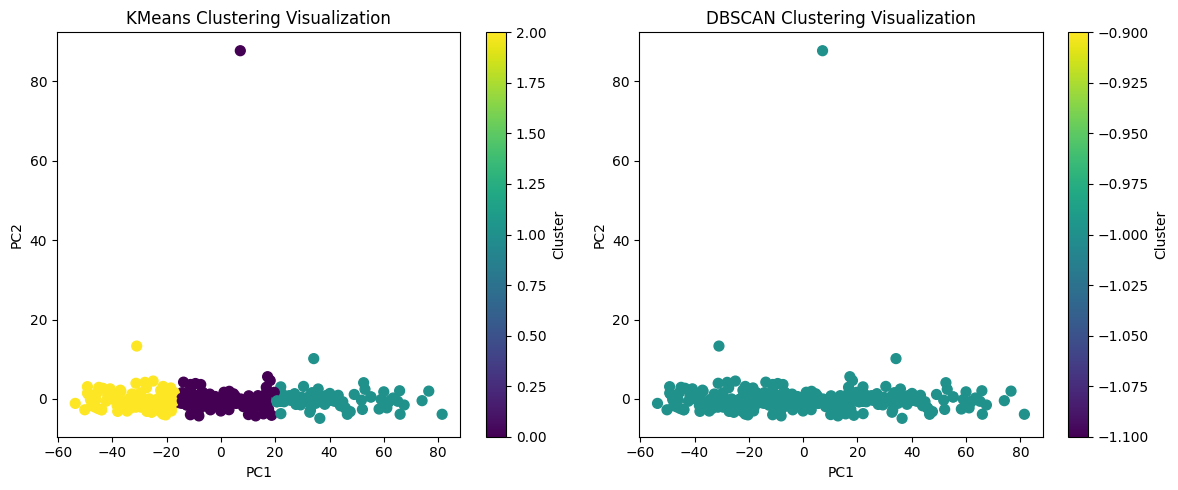

In [ ]:
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np

# Assuming final_embeddings come from your trained model
# For example:
final_embeddings = pred_embeddings.detach().cpu().numpy()  # shape: [N, proj_dim]

# ---------- KMeans Clustering ----------
# Choose a number of clusters, e.g., k=3 (change as appropriate)
k = 3
kmeans = KMeans(n_clusters=k, random_state=42).fit(final_embeddings)
labels_kmeans = kmeans.labels_

# Compute clustering evaluation metrics for KMeans
silhouette_kmeans = silhouette_score(final_embeddings, labels_kmeans)
ch_kmeans         = calinski_harabasz_score(final_embeddings, labels_kmeans)
db_kmeans         = davies_bouldin_score(final_embeddings, labels_kmeans)

print("KMeans Clustering Metrics:")
print("Silhouette Score: {:.4f}".format(silhouette_kmeans))
print("Calinski-Harabasz Score: {:.4f}".format(ch_kmeans))
print("Davies-Bouldin Score: {:.4f}".format(db_kmeans))

# ---------- DBSCAN Clustering ----------
# Choose DBSCAN parameters (adjust eps and min_samples to your data)
dbscan = DBSCAN(eps=0.5, min_samples=5).fit(final_embeddings)
labels_dbscan = dbscan.labels_
# DBSCAN labels outliers as -1
unique_labels_db = np.unique(labels_dbscan)
print("\nDBSCAN found clusters:", unique_labels_db)

# Some clustering evaluation metrics (silhouette score) require at least 2 clusters.
# We'll compute the metrics only if more than one cluster is found (excluding outliers):
mask = (labels_dbscan != -1)
if np.sum(mask) > 1 and len(np.unique(labels_dbscan[mask])) > 1:
    silhouette_dbscan = silhouette_score(final_embeddings[mask], labels_dbscan[mask])
    ch_dbscan = calinski_harabasz_score(final_embeddings[mask], labels_dbscan[mask])
    db_dbscan = davies_bouldin_score(final_embeddings[mask], labels_dbscan[mask])
    print("DBSCAN Clustering Metrics (excluding outliers):")
    print("Silhouette Score: {:.4f}".format(silhouette_dbscan))
    print("Calinski-Harabasz Score: {:.4f}".format(ch_dbscan))
    print("Davies-Bouldin Score: {:.4f}".format(db_dbscan))
else:
    print("DBSCAN did not find enough clusters for metric evaluation.")

# ---------- Visualization: Scatter Plot of Clusters ----------
# Reduce dimensionality to 2D for visualization (using PCA)
pca = PCA(n_components=2)
reduced_embeddings = pca.fit_transform(final_embeddings)

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.scatter(reduced_embeddings[:, 0], reduced_embeddings[:, 1],
            c=labels_kmeans, cmap='viridis', s=50)
plt.title("KMeans Clustering Visualization")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.colorbar(label='Cluster')

plt.subplot(1, 2, 2)
plt.scatter(reduced_embeddings[:, 0], reduced_embeddings[:, 1],
            c=labels_dbscan, cmap='viridis', s=50)
plt.title("DBSCAN Clustering Visualization")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.colorbar(label='Cluster')
plt.tight_layout()
plt.show()


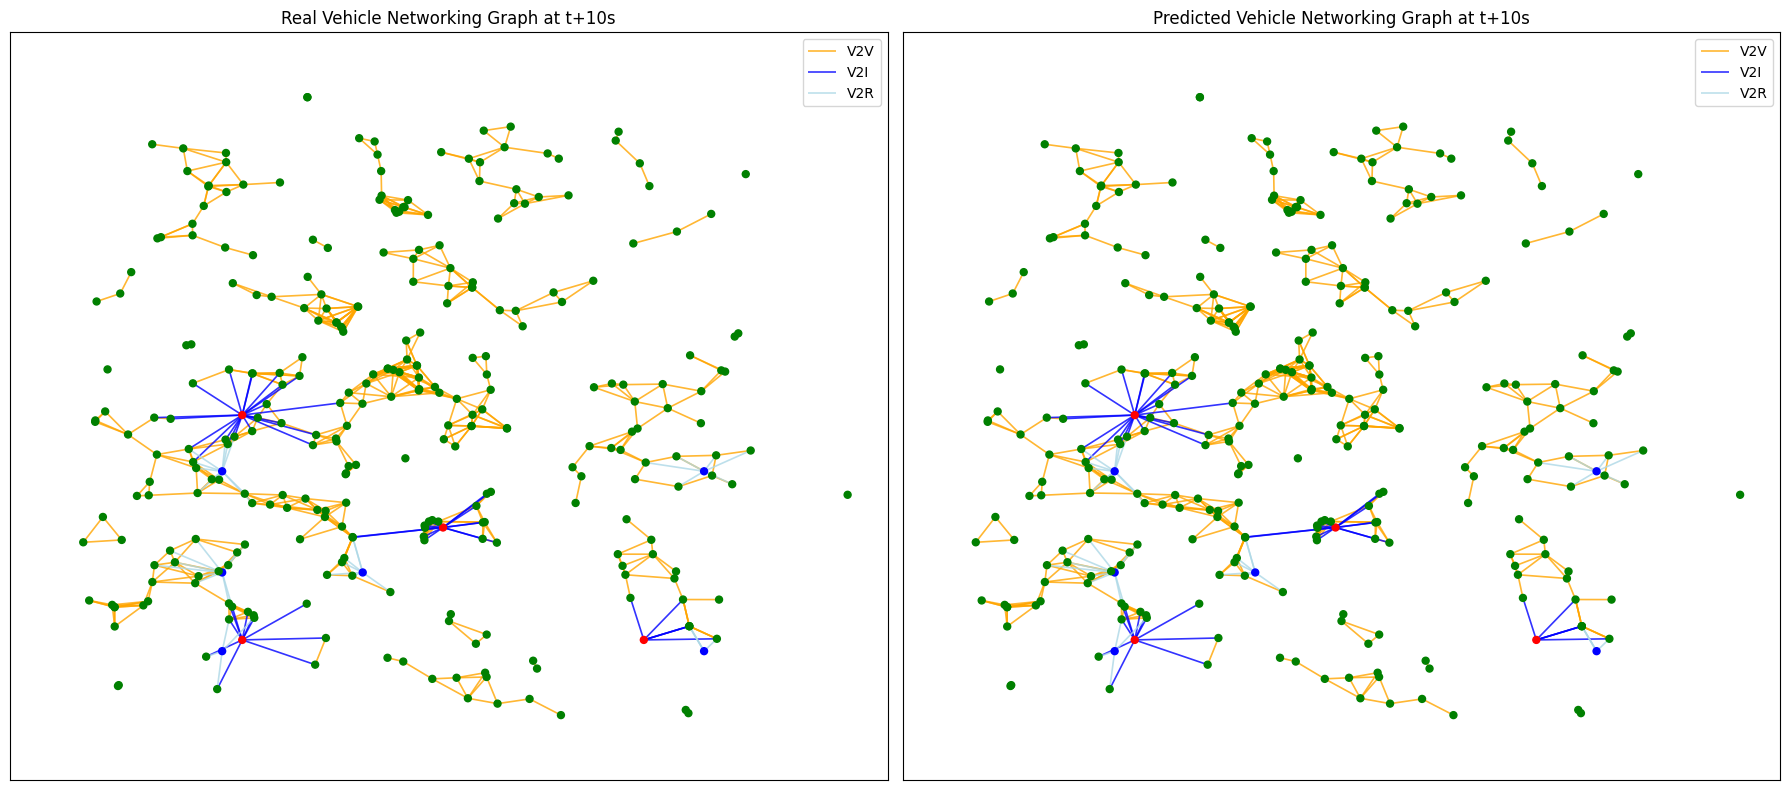

In [ ]:
import matplotlib.pyplot as plt
import networkx as nx
pred_graphs_over_time = []  # Store all predicted graphs over 10s

for t in range(target_index - 9, target_index + 1):  # Predict for last 10 seconds
    pred_graph = dynamic_graphs[t]  # Replace with actual predicted graph logic
    pred_graphs_over_time.append(pred_graph)

def visualize_real_vs_predicted_network(true_graph, predicted_graph):
    """
    Plots the real and predicted vehicle networking graphs side by side.
    """
    fig, axes = plt.subplots(1, 2, figsize=(18, 8))

    def draw_graph(ax, G, title):
        pos = nx.get_node_attributes(G, "pos")

        # Define node colors
        node_colors = []
        for _, data in G.nodes(data=True):
            if data["type"] == "car":
                node_colors.append("green")
            elif data["type"] == "Tower":
                node_colors.append("red")
            elif data["type"] == "RSU":
                node_colors.append("blue")

        # Draw network
        ax.set_title(title)
        nx.draw_networkx_nodes(G, pos, node_color=node_colors, ax=ax, node_size=25)

        # Draw edges based on type
        v2v_edges = [(u, v) for u, v, d in G.edges(data=True) if d["type"] == "V2V"]
        v2i_edges = [(u, v) for u, v, d in G.edges(data=True) if d["type"] == "V2I"]
        v2r_edges = [(u, v) for u, v, d in G.edges(data=True) if d["type"] == "V2R"]

        nx.draw_networkx_edges(G, pos, edgelist=v2v_edges, edge_color="orange", width=1.2, alpha=0.8, ax=ax, label="V2V")
        nx.draw_networkx_edges(G, pos, edgelist=v2i_edges, edge_color="blue", width=1.2, alpha=0.8, ax=ax, label="V2I")
        nx.draw_networkx_edges(G, pos, edgelist=v2r_edges, edge_color="lightblue", width=1.2, alpha=0.8, ax=ax, label="V2R")

        ax.legend()

    # Plot both graphs: Real vs Predicted
    draw_graph(axes[0], true_graph, "Real Vehicle Networking Graph at t+10s")
    draw_graph(axes[1], predicted_graph, "Predicted Vehicle Networking Graph at t+10s")

    plt.tight_layout()
    plt.show()

# ✅ Ensure correct variables before running
start = 0  # If not already set
input_len = 50  # Length of input sequence
target_offset = 10  # Predict t+10s
target_index = start + input_len + target_offset - 1  # Final prediction time index

# Get true and predicted graphs
true_graph = dynamic_graphs[target_index]  # Real network at t+10s
predicted_graph = pred_graphs_over_time[-1]  # Last predicted graph in the sequence

# Call function to visualize
visualize_real_vs_predicted_network(true_graph, predicted_graph)


<ipython-input-13-e21d48e49944>:21: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cluster_colors = plt.cm.get_cmap("tab10", n_clusters)


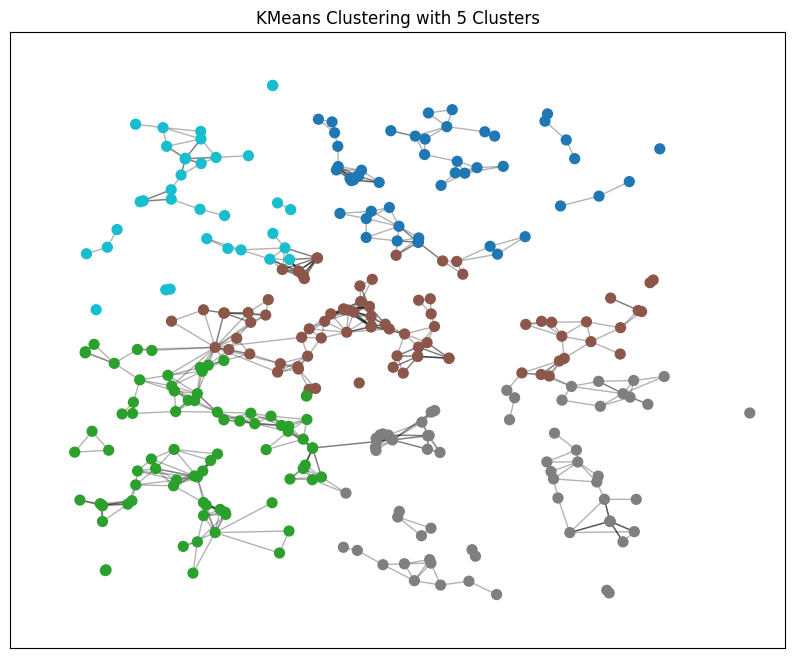

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from sklearn.cluster import KMeans

def visualize_kmeans_with_edges(graph, n_clusters=5):
    """
    Perform KMeans clustering on the graph's nodes and visualize with edges.
    """
    pos = nx.get_node_attributes(graph, "pos")

    # Extract positions as numpy array for clustering
    node_list = list(graph.nodes())
    positions = np.array([pos[n] for n in node_list])

    # Perform KMeans clustering
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    cluster_labels = kmeans.fit_predict(positions)

    # Assign cluster labels to nodes
    cluster_colors = plt.cm.get_cmap("tab10", n_clusters)

    # Draw graph with clusters
    plt.figure(figsize=(10, 8))
    nx.draw_networkx_nodes(graph, pos, nodelist=node_list, node_color=[cluster_colors(c) for c in cluster_labels], node_size=50)

    # Draw edges
    nx.draw_networkx_edges(graph, pos, edgelist=graph.edges(), alpha=0.3, width=1.0)

    # Show clusters
    plt.title(f"KMeans Clustering with {n_clusters} Clusters")
    plt.show()

# ✅ Define missing variables before running
start = 0  # The starting time index
input_len = 50  # Length of input sequence
target_offset = 10  # Predict t+10s
target_index = start + input_len + target_offset - 1  # The last time step for prediction

# ✅ Select the predicted graph for clustering
predicted_graph = pred_graphs_over_time[-1]  # Last predicted network at t+10s

# Run clustering visualization
visualize_kmeans_with_edges(predicted_graph, n_clusters=5)


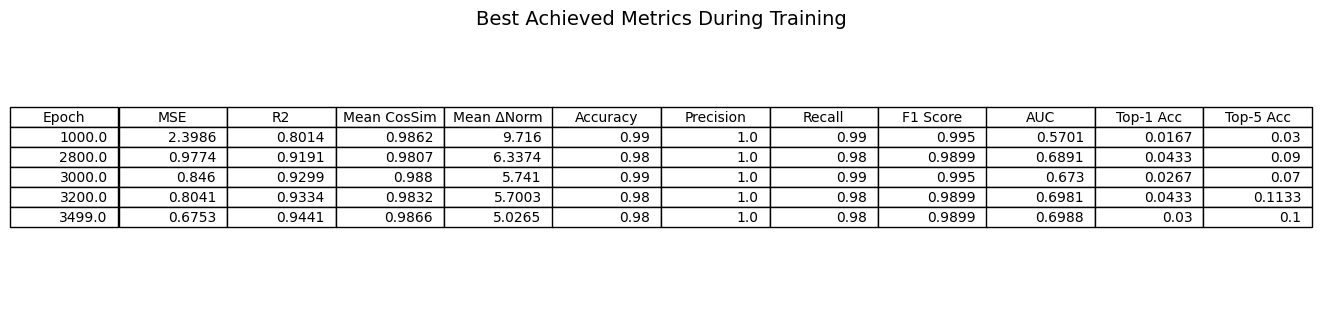

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Create DataFrame from logged metrics
metrics_df = pd.DataFrame({
    'Epoch': logged_epochs,
    'MSE': logged_mse,
    'R2': logged_r2,
    'Mean CosSim': logged_mean_cos,
    'Mean ΔNorm': logged_mean_diff,
    'Accuracy': logged_accuracy,
    'Precision': logged_precision,
    'Recall': logged_recall,
    'F1 Score': logged_f1,
    'AUC': logged_auc,
    'Top-1 Acc': logged_top1,
    'Top-5 Acc': logged_top5
})

# Columns to maximize and minimize
maximize_cols = ['R2', 'Mean CosSim', 'Accuracy', 'Precision', 'Recall', 'F1 Score', 'AUC', 'Top-1 Acc', 'Top-5 Acc']
minimize_cols = ['MSE', 'Mean ΔNorm']

# Collect best rows as DataFrames
best_rows = []
for col in maximize_cols:
    idx = metrics_df[col].idxmax()
    best_rows.append(metrics_df.iloc[[idx]])  # Wrap in double brackets to keep as DataFrame

for col in minimize_cols:
    idx = metrics_df[col].idxmin()
    best_rows.append(metrics_df.iloc[[idx]])

# Combine and drop duplicate epochs (if any), sort by epoch
best_metrics_df = pd.concat(best_rows).drop_duplicates(subset='Epoch').sort_values(by='Epoch')

# Plot table
fig, ax = plt.subplots(figsize=(14, 1 + 0.5 * len(best_metrics_df)))
ax.axis('off')
table = ax.table(cellText=best_metrics_df.round(4).values,
                 colLabels=best_metrics_df.columns,
                 loc='center')
table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1.2, 1.2)
plt.title("Best Achieved Metrics During Training", fontsize=14)
plt.show()


In [ ]:
import matplotlib.pyplot as plt

# --- Plot 1: Accuracy ---
plt.figure(figsize=(8, 5))
plt.plot(logged_epochs, logged_accuracy, color='black')
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim(0.9, 1)  # Focus range
plt.grid(True)
plt.tight_layout()
plt.savefig('accuracy_over_epochs.jpg', format='jpg')
plt.close()

# --- Plot 2: Precision ---
plt.figure(figsize=(8, 5))
plt.plot(logged_epochs, logged_precision, color='orange')
plt.title('Precision over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Precision')
plt.ylim(0.9, 1)  # Focus range
plt.grid(True)
plt.tight_layout()
plt.savefig('precision_over_epochs.jpg', format='jpg')
plt.close()

# --- Plot 3: Recall ---
plt.figure(figsize=(8, 5))
plt.plot(logged_epochs, logged_recall, color='green')
plt.title('Recall over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Recall')
plt.ylim(0.9, 1)  # Focus range
plt.grid(True)
plt.tight_layout()
plt.savefig('recall_over_epochs.jpg', format='jpg')
plt.close()

# --- Plot 4: F1 Score ---
plt.figure(figsize=(8, 5))
plt.plot(logged_epochs, logged_f1, color='blue')
plt.title('F1 Score over Epochs')
plt.xlabel('Epoch')
plt.ylabel('F1 Score')
plt.ylim(0.9, 1)  # Focus range
plt.grid(True)
plt.tight_layout()
plt.savefig('f1_score_over_epochs.jpg', format='jpg')
plt.close()
